# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [2]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [2]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [6]:
# XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
# api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
# from IPython.display import IFrame
# IFrame(src=XDSM_FILE, width='100%', height='500px')

## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [6]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [7]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.11 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.023996700000001425 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [8]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

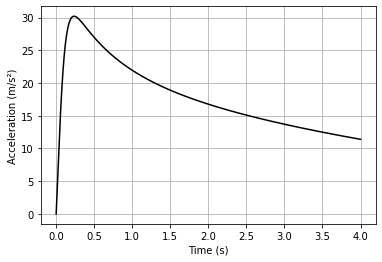

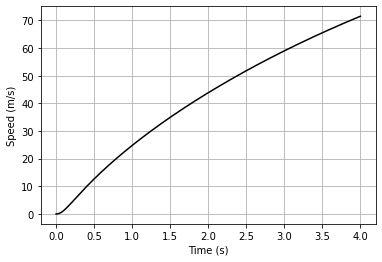

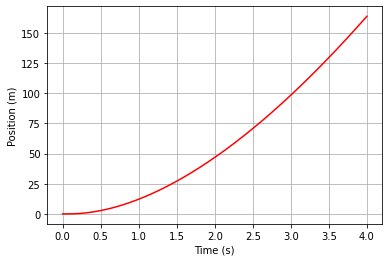

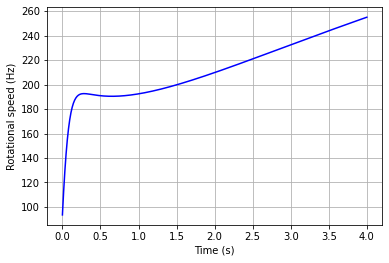

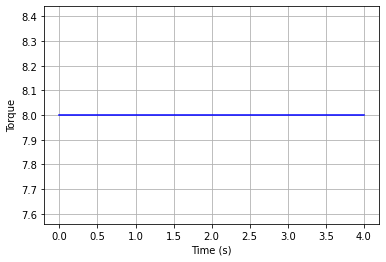

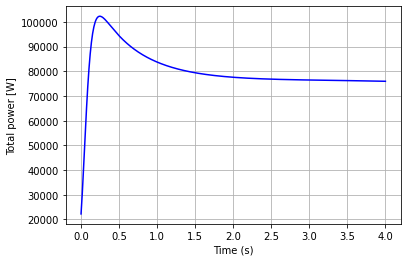

In [9]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [10]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [11]:
api.optimization_viewer(CONFIGURATION_FILE)

In [9]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01825490000010177 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018402200000309676 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0200976999994964 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.017952100000002247 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018039099999441532 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018118899999535643 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018426200000249082 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01814089999970747 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.019317

Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.021409300000414078 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.01898570000048494 seconds.
Simulation interval    : 0.0 - 3.986299670367458 seconds.
Elapsed simulation time: 0.018417600000248058 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.0180212000004758 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.019295999999485502 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.019891500000085216 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.01876410000022588 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.020268600000235892 seconds.
Simulation interval    : 0.0 - 3.945179955428095 seconds.
Elapsed simulation time: 0.019313499999952

Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.020275100000617385 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018744799999694806 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018835099999705562 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018373300000348536 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018695700000534998 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018335900000238325 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018375399999968067 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.018232300000818213 seconds.
Simulation interval    : 0.0 - 3.8774782016712916 seconds.
Elapsed simulation time: 0.01

Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.02361800000016956 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.020045000000209257 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.020561000000270724 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018543700000009267 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.02016600000024482 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018847299999833922 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018933299999844166 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.018759000000500237 seconds.
Simulation interval    : 0.0 - 3.452763851139741 seconds.
Elapsed simulation time: 0.0190577000003

Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018490299999939452 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.01869689999966795 seconds.
Simulation interval    : 0.0 - 2.4779079728865394 seconds.
Elapsed simulation time: 0.01877150000018446 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.018467900000359805 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.01876300000003539 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.019077300000390096 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.020134999999754655 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.019236999999520776 seconds.
Simulation interval    : 0.0 - 2.4779069728865397 seconds.
Elapsed simulation time: 0.01913

Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.028029000000060478 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.024847599999702652 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.024105299999973795 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.02970649999952002 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.019381699999939883 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.018894299999374198 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.019103600000562437 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.019566899999517773 seconds.
Simulation interval    : 0.0 - 2.3030595029829812 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.02971109999998589 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.0188428000001295 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.020149599999967904 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.019495000000461005 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.02855329999965761 seconds.
Simulation interval    : 0.0 - 2.3648338426888156 seconds.
Elapsed simulation time: 0.07059730000037234 seconds.
Simulation interval    : 0.0 - 2.5190778724005964 seconds.
Elapsed simulation time: 0.029280800000378804 seconds.
Simulation interval    : 0.0 - 2.3907019352081837 seconds.
Elapsed simulation time: 0.024186599999666214 seconds.
Simulation interval    : 0.0 - 2.370006770550648 seconds.
Elapsed simulation time: 0.01931090

Simulation interval    : 0.0 - 2.4148647500938103 seconds.
Elapsed simulation time: 0.02301149999948393 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.02431310000065423 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.019438399999671674 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.024350000000595173 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.027618900000561553 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.023371600000245962 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.025765699999283243 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.03263729999980569 seconds.
Simulation interval    : 0.0 - 2.41486375009381 seconds.
Elapsed simulation time: 0.022673999999824446 se

Simulation interval    : 0.0 - 2.4223570888184756 seconds.
Elapsed simulation time: 0.018801100000018778 seconds.
Simulation interval    : 0.0 - 2.4223570888184756 seconds.
Elapsed simulation time: 0.020205300000270654 seconds.
Simulation interval    : 0.0 - 2.713352741885205 seconds.
Elapsed simulation time: 0.021846300000106567 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.01905319999968924 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.018611999999848194 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.01831289999972796 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.018240000000332657 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.01852009999947768 seconds.
Simulation interval    : 0.0 - 2.4618192373136787 seconds.
Elapsed simulation time: 0.024049

Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018782900000587688 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.019019000000298547 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018442900000081863 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.01837119999981951 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018533499999648484 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018270399999892106 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.01835990000017773 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.018289800000275136 seconds.
Simulation interval    : 0.0 - 2.5333099883061614 seconds.
Elapsed simulation time: 0.0186

Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.0188441000000239 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018483300000298186 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.01826080000046204 seconds.
Simulation interval    : 0.0 - 2.5585267756970103 seconds.
Elapsed simulation time: 0.01830549999976938 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018766499999401276 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.01847600000019156 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018512200000259327 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.01833749999968859 seconds.
Simulation interval    : 0.0 - 2.55852577569701 seconds.
Elapsed simulation time: 0.018347300000641553 secon

Simulation interval    : 0.0 - 2.70862714783497 seconds.
Elapsed simulation time: 0.018102700000781624 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.01817959999971208 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.01834710000002815 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018539899999268528 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.02022709999982908 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018150700000660436 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018593699999655655 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018477900000107184 seconds.
Simulation interval    : 0.0 - 2.674936301449675 seconds.
Elapsed simulation time: 0.018244300000333

Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.018503100000089034 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.018449199999849952 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01805659999990894 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01837340000020049 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.02005710000048566 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01873799999975745 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01843989999997575 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01825250000001688 seconds.
Simulation interval    : 0.0 - 2.687414174456814 seconds.
Elapsed simulation time: 0.01952150000033725

Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.018312000000150874 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.018094600000040373 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.01829490000000078 seconds.
Simulation interval    : 0.0 - 2.768615783667156 seconds.
Elapsed simulation time: 0.018157200000132434 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.01844150000033551 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.018442700000377954 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.018360900000516267 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.01897759999974369 seconds.
Simulation interval    : 0.0 - 2.768614783667156 seconds.
Elapsed simulation time: 0.01839529999961

Simulation interval    : 0.0 - 2.82812816833485 seconds.
Elapsed simulation time: 0.019002099999852362 seconds.
Simulation interval    : 0.0 - 3.1847230962643267 seconds.
Elapsed simulation time: 0.021325400000023365 seconds.
Simulation interval    : 0.0 - 2.8637876611277973 seconds.
Elapsed simulation time: 0.0184811000008267 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018997699999999895 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.021442100000058417 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.01835690000007162 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018422300000565883 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.018577499999992142 seconds.
Simulation interval    : 0.0 - 2.8316941176141444 seconds.
Elapsed simulation time: 0.0185362

Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01908389999971405 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01890319999984058 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01869009999973059 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01805190000050061 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.018606499999805237 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.018644900000253983 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01884870000048977 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01871119999941584 seconds.
Simulation interval    : 0.0 - 2.8390993359092582 seconds.
Elapsed simulation time: 0.01878379

Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.01893649999965419 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.018339600000217615 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.019384299999728682 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.01920849999987695 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.019774899999902118 seconds.
Simulation interval    : 0.0 - 2.8473333185760863 seconds.
Elapsed simulation time: 0.02134680000017397 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.019144399999277084 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.018826399999852583 seconds.
Simulation interval    : 0.0 - 2.8473323185760857 seconds.
Elapsed simulation time: 0.01822

Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.019028099999559345 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.02110990000073798 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.02092259999972157 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.01899020000018936 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.01843410000037693 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.018514999999752035 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.020856400000411668 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.019010800000614836 seconds.
Simulation interval    : 0.0 - 3.1299249990650315 seconds.
Elapsed simulation time: 0.018958

Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.019704999999703432 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.01894319999973959 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018250899999657122 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.01926180000009481 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018612900000334776 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.0183247000004485 seconds.
Simulation interval    : 0.0 - 3.0073757699880312 seconds.
Elapsed simulation time: 0.018131399999219866 seconds.
Simulation interval    : 0.0 - 3.059029349359447 seconds.
Elapsed simulation time: 0.018937300000288815 seconds.
Simulation interval    : 0.0 - 3.012541127925173 seconds.
Elapsed simulation time: 0.01948819

Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.01886800000011135 seconds.
Simulation interval    : 0.0 - 3.0079822377243657 seconds.
Elapsed simulation time: 0.021667100000740902 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018884100000832404 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018932899999526853 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018692900000132795 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.01919400000042515 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018969400000059977 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.018579099999442406 seconds.
Simulation interval    : 0.0 - 3.007981237724366 seconds.
Elapsed simulation time: 0.020645200000

Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.018434200000228884 seconds.
Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.019471300000077463 seconds.
Simulation interval    : 0.0 - 2.9575031327111 seconds.
Elapsed simulation time: 0.01843139999982668 seconds.
Simulation interval    : 0.0 - 3.1028422069856902 seconds.
Elapsed simulation time: 0.018563999999969383 seconds.
Simulation interval    : 0.0 - 2.9720370401385594 seconds.
Elapsed simulation time: 0.018984399999681045 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.01885020000008808 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.01858410000022559 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.019577900000513182 seconds.
Simulation interval    : 0.0 - 2.963896093168799 seconds.
Elapsed simulation time: 0.019572100000004866

Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.01840829999946436 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018468700000084937 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.019437699999798497 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018268300000272575 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018613100000038685 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.019658700000036333 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.018743800000265765 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.01879189999999653 seconds.
Simulation interval    : 0.0 - 2.984706412396935 seconds.
Elapsed simulation time: 0.0185071999994

Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.019463700000414974 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.018499200000405835 seconds.
Simulation interval    : 0.0 - 2.9944471026115016 seconds.
Elapsed simulation time: 0.018793600000208244 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.018604200000481796 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.020761999999194813 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.01911500000005617 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.018846099999791477 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.02037240000026941 seconds.
Simulation interval    : 0.0 - 2.9944461026115015 seconds.
Elapsed simulation time: 0.0187

Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.019041800000195508 seconds.
Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.020292899999731162 seconds.
Simulation interval    : 0.0 - 2.9932593222475625 seconds.
Elapsed simulation time: 0.018837300000086543 seconds.
Simulation interval    : 0.0 - 2.82914560268935 seconds.
Elapsed simulation time: 0.018389000000752276 seconds.
Simulation interval    : 0.0 - 2.9679547124610406 seconds.
Elapsed simulation time: 0.019123000000035972 seconds.
Simulation interval    : 0.0 - 2.9886103742733003 seconds.
Elapsed simulation time: 0.019187099999726343 seconds.
Simulation interval    : 0.0 - 2.9922527405035932 seconds.
Elapsed simulation time: 0.019409300000006624 seconds.
Simulation interval    : 0.0 - 2.992999362523904 seconds.
Elapsed simulation time: 0.01939609999953973 seconds.
Simulation interval    : 0.0 - 2.9931722527410924 seconds.
Elapsed simulation time: 0.019217

Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.01891559999967285 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.01870139999937237 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.02182699999957549 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.01899819999925967 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.020834599999943748 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.018445700000484067 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.019279000000096858 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.019517499999892607 seconds.
Simulation interval    : 0.0 - 3.024567868952954 seconds.
Elapsed simulation time: 0.018584999999802

Simulation interval    : 0.0 - 3.0359897875848345 seconds.
Elapsed simulation time: 0.01974289999998291 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.0190216999999393 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.01927510000041366 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.01881240000057005 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018922000000202388 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.01843250000001717 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.018513300000449817 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.01847849999921891 seconds.
Simulation interval    : 0.0 - 3.02911493232961 seconds.
Elapsed simulation time: 0.0192786999996315 seconds.

Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.018896000000495405 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019258499999523337 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.01907559999926889 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.01837809999960882 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019922600000427337 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.021524200000385463 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.019087300000137475 seconds.
Simulation interval    : 0.0 - 3.0302927100678634 seconds.
Elapsed simulation time: 0.018907699999545002 seconds.
Simulation interval    : 0.0 - 3.060027809170363 seconds.
Elapsed simulation time: 0.02085

Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.019400200000745826 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.018320300000596035 seconds.
Simulation interval    : 0.0 - 3.031261623890943 seconds.
Elapsed simulation time: 0.018943900000522262 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.018725699999777135 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.019014900000001944 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.01863279999997758 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.01872899999943911 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.02164930000071763 seconds.
Simulation interval    : 0.0 - 3.031260623890943 seconds.
Elapsed simulation time: 0.01857860000018

Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.01971380000031786 seconds.
Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.018388599999525468 seconds.
Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.01930770000035409 seconds.
Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.018799800000124378 seconds.
Simulation interval    : 0.0 - 3.0312801222079773 seconds.
Elapsed simulation time: 0.01866729999983363 seconds.
Simulation interval    : 0.0 - 2.9791696537624146 seconds.
Elapsed simulation time: 0.02039169999989099 seconds.
Simulation interval    : 0.0 - 3.019511697087289 seconds.
Elapsed simulation time: 0.01880799999980809 seconds.
Simulation interval    : 0.0 - 3.0292160203825005 seconds.
Elapsed simulation time: 0.019035999999687192 seconds.
Simulation interval    : 0.0 - 3.0310737120254294 seconds.
Elapsed simulation time: 0.01988640

Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.018437100000483042 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.02122220000001107 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.019547499999134743 seconds.
Simulation interval    : 0.0 - 3.024454847905528 seconds.
Elapsed simulation time: 0.019125800000438176 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.01826580000033573 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.01852969999981724 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.019101900000350724 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.018534400000135065 seconds.
Simulation interval    : 0.0 - 3.024453847905528 seconds.
Elapsed simulation time: 0.01984629999969

Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.01836630000070727 seconds.
Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.018805800000336603 seconds.
Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.019155699999828357 seconds.
Simulation interval    : 0.0 - 3.024505590690062 seconds.
Elapsed simulation time: 0.01850029999968683 seconds.
Simulation interval    : 0.0 - 3.033963140547321 seconds.
Elapsed simulation time: 0.01925699999992503 seconds.
Simulation interval    : 0.0 - 3.0255515123473384 seconds.
Elapsed simulation time: 0.02086929999950371 seconds.
Simulation interval    : 0.0 - 3.0246101828557896 seconds.
Elapsed simulation time: 0.019403000000238535 seconds.
Simulation interval    : 0.0 - 3.0245160499066355 seconds.
Elapsed simulation time: 0.018852500000321015 seconds.
Simulation interval    : 0.0 - 3.0245160499066355 seconds.
Elapsed simulation time: 0.01944929999

Simulation interval    : 0.0 - 3.02458679326285 seconds.
Elapsed simulation time: 0.018490700000256766 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.02020170000014332 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.019689200000357232 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.01875579999978072 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018787699999847973 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018227799999294803 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018497600000046077 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018894900000304915 seconds.
Simulation interval    : 0.0 - 3.0245857932628497 seconds.
Elapsed simulation time: 0.018180

Simulation interval    : 0.0 - 3.024535319313479 seconds.
Elapsed simulation time: 0.019232999999985623 seconds.
Simulation interval    : 0.0 - 3.024535319313479 seconds.
Elapsed simulation time: 0.018621699999130215 seconds.
Simulation interval    : 0.0 - 3.058417623187655 seconds.
Elapsed simulation time: 0.02133589999994001 seconds.
Simulation interval    : 0.0 - 3.0320644440975637 seconds.
Elapsed simulation time: 0.01954349999959959 seconds.
Simulation interval    : 0.0 - 3.0252882317918877 seconds.
Elapsed simulation time: 0.01945140000043466 seconds.
Simulation interval    : 0.0 - 3.0246106105613193 seconds.
Elapsed simulation time: 0.01880399999936344 seconds.
Simulation interval    : 0.0 - 3.024542848438263 seconds.
Elapsed simulation time: 0.019242999999733 seconds.
Simulation interval    : 0.0 - 3.024542848438263 seconds.
Elapsed simulation time: 0.019222800000534335 seconds.
Simulation interval    : 0.0 - 3.024542848438263 seconds.
Elapsed simulation time: 0.018924899999547

Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019054200000027777 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019770300000345742 seconds.
Simulation interval    : 0.0 - 3.0245543854616126 seconds.
Elapsed simulation time: 0.018438699999933306 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.02072260000022652 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.01829890000044543 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019244300000536896 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019085599999925762 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.019012300000213145 seconds.
Simulation interval    : 0.0 - 3.024553385461612 seconds.
Elapsed simulation time: 0.018743799999

Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.018710399999690708 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.018676099999538565 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.01843860000008135 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.019709299999703944 seconds.
Simulation interval    : 0.0 - 3.024562173720026 seconds.
Elapsed simulation time: 0.01849210000000312 seconds.
Simulation interval    : 0.0 - 3.0693330577357205 seconds.
Elapsed simulation time: 0.020627500000045984 seconds.
Simulation interval    : 0.0 - 3.029039262121595 seconds.
Elapsed simulation time: 0.01891390000037063 seconds.
Simulation interval    : 0.0 - 3.0250098825601834 seconds.
Elapsed simulation time: 0.018582299999252427 seconds.
Simulation interval    : 0.0 - 3.0246069446040416 seconds.
Elapsed simulation time: 0.01968800000

Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.019074599999839847 seconds.
Simulation interval    : 0.0 - 3.025313591349919 seconds.
Elapsed simulation time: 0.018334400000640017 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.019209300000511575 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.019263600000158476 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.01844210000035673 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.01812069999959931 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.01860359999955108 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.019048299999667506 seconds.
Simulation interval    : 0.0 - 3.0253125913499193 seconds.
Elapsed simulation time: 0.018835

Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.018657399999938207 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.01838080000015907 seconds.
Simulation interval    : 0.0 - 3.0253443909156132 seconds.
Elapsed simulation time: 0.03385499999967578 seconds.
Simulation interval    : 0.0 - 3.0232946789416744 seconds.
Elapsed simulation time: 0.018411600000035833 seconds.
Simulation interval    : 0.0 - 3.025139419718219 seconds.
Elapsed simulation time: 0.01878729999953066 seconds.
Simulation interval    : 0.0 - 3.0253201077654435 seconds.
Elapsed simulation time: 0.019003099999281403 seconds.
Simulation interval    : 0.0 - 3.025341481387964 seconds.
Elapsed simulation time: 0.01965420000033191 seconds.
Simulation interval    : 0.0 - 3.0253440334694557 seconds.
Elapsed simulation time: 0.018717900000410737 seconds.
Simulation interval    : 0.0 - 3.025344336209342 seconds.
Elapsed simulation time: 0.020165699

Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.01893999999992957 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.01830580000023474 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.019224300000132644 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.018634999999449064 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.01925200000005134 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.01859980000062933 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.018801999999595864 seconds.
Simulation interval    : 0.0 - 3.0253439727242366 seconds.
Elapsed simulation time: 0.019090099999630183 seconds.
Simulation interval    : 0.0 - 3.025344972724237 seconds.
Elapsed simulation time: 0.0184963

Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.01911110000037297 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.01966889999948762 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.01903920000040671 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.018846499999199295 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.018433700000059616 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.018997500000295986 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.018803799999659532 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.019013000000086322 seconds.
Simulation interval    : 0.0 - 3.025343887261074 seconds.
Elapsed simulation time: 0.01906870000038

Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.023192599999674712 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.018511100000068836 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.019301999999697728 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.01865040000029694 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.01876220000031026 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.018889700000727316 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.019021999999495165 seconds.
Simulation interval    : 0.0 - 3.0253439230717127 seconds.
Elapsed simulation time: 0.019503900000017893 seconds.
Simulation interval    : 0.0 - 3.1162811160985546 seconds.
Elapsed simulation time: 0.0205

Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.018689099999392056 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.01900770000065677 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.019695799999681185 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.018983699999807868 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.020053299999744922 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.018587000000479748 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.019737200000236044 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.018558899999334244 seconds.
Simulation interval    : 0.0 - 3.025411746683073 seconds.
Elapsed simulation time: 0.018834700000

Elapsed simulation time: 0.01854269999967073 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.019446700000116834 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018388699999377423 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.018742999999631138 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.01853339999979653 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.01885960000072373 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.01869390000047133 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.01893090000066877 seconds.
Simulation interval    : 0.0 - 3.025478753321835 seconds.
Elapsed simulation time: 0.01868280000053346 seconds.
Simulation interval    : 0.0 - 3.02547875332183

Simulation interval    : 0.0 - 3.0255153565031194 seconds.
Elapsed simulation time: 0.01883709999947314 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.019137600000249222 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.019499099999848113 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.0188970999997764 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.018796399999700952 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.018536100000346778 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.018670899999960966 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.018685099999856902 seconds.
Simulation interval    : 0.0 - 3.0255082789807557 seconds.
Elapsed simulation time: 0.02284

Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.01877839999997377 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.01924059999964811 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.01976970000032452 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019061299999520998 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.018225499999971362 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019109199999547855 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019680499999594758 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.019423599999754515 seconds.
Simulation interval    : 0.0 - 3.0255094264182127 seconds.
Elapsed simulation time: 0.01927

Simulation interval    : 0.0 - 3.025510985854472 seconds.
Elapsed simulation time: 0.018208400000730762 seconds.
Simulation interval    : 0.0 - 3.0374794886946295 seconds.
Elapsed simulation time: 0.018634400000337337 seconds.
Simulation interval    : 0.0 - 3.026707836138488 seconds.
Elapsed simulation time: 0.018578700000034587 seconds.
Simulation interval    : 0.0 - 3.0256306708828737 seconds.
Elapsed simulation time: 0.019898500000635977 seconds.
Simulation interval    : 0.0 - 3.0255229543573123 seconds.
Elapsed simulation time: 0.01901700000053097 seconds.
Simulation interval    : 0.0 - 3.0255121827047557 seconds.
Elapsed simulation time: 0.018592999999782478 seconds.
Simulation interval    : 0.0 - 3.0255121827047557 seconds.
Elapsed simulation time: 0.02026430000023538 seconds.
Simulation interval    : 0.0 - 3.0255121827047557 seconds.
Elapsed simulation time: 0.03578319999996893 seconds.
Simulation interval    : 0.0 - 3.0255121827047557 seconds.
Elapsed simulation time: 0.0191997

Simulation interval    : 0.0 - 3.025516559294158 seconds.
Elapsed simulation time: 0.018962300000566756 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.019813599999906728 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01847170000019105 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01903240000046935 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.01852989999952115 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.019138600000587758 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.018690500000047905 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.0181615999999849 seconds.
Simulation interval    : 0.0 - 3.025515559294158 seconds.
Elapsed simulation time: 0.0185593000005610

Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.018956099999741127 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.019940300000598654 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.018773299999338633 seconds.
Simulation interval    : 0.0 - 3.0255160127676963 seconds.
Elapsed simulation time: 0.019909800000277755 seconds.
Simulation interval    : 0.0 - 3.0568721808068036 seconds.
Elapsed simulation time: 0.018902499999967404 seconds.
Simulation interval    : 0.0 - 3.028651629571607 seconds.
Elapsed simulation time: 0.01907429999937449 seconds.
Simulation interval    : 0.0 - 3.025829574448087 seconds.
Elapsed simulation time: 0.018854500000088592 seconds.
Simulation interval    : 0.0 - 3.0255473689357353 seconds.
Elapsed simulation time: 0.018741700000646233 seconds.
Simulation interval    : 0.0 - 3.0255191483845003 seconds.
Elapsed simulation time: 0.01985

Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.018411200000628014 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.03884499999912805 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01893240000026708 seconds.
Simulation interval    : 0.0 - 3.026134560499853 seconds.
Elapsed simulation time: 0.01912079999965499 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.018553100000644918 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.018558899999334244 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01930179999999382 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01933660000031523 seconds.
Simulation interval    : 0.0 - 3.0261335604998525 seconds.
Elapsed simulation time: 0.01879999

Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.018490200000087498 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.020285499999772583 seconds.
Simulation interval    : 0.0 - 3.0277364946801324 seconds.
Elapsed simulation time: 0.018408300000373856 seconds.
Simulation interval    : 0.0 - 3.1048202737084356 seconds.
Elapsed simulation time: 0.01868560000002617 seconds.
Simulation interval    : 0.0 - 3.035444872582963 seconds.
Elapsed simulation time: 0.019110799999907613 seconds.
Simulation interval    : 0.0 - 3.0285073324704155 seconds.
Elapsed simulation time: 0.018383300000095915 seconds.
Simulation interval    : 0.0 - 3.0285073324704155 seconds.
Elapsed simulation time: 0.019775400000071386 seconds.
Simulation interval    : 0.0 - 3.0285073324704155 seconds.
Elapsed simulation time: 0.019029100000807375 seconds.
Simulation interval    : 0.0 - 3.0285073324704155 seconds.
Elapsed simulation time: 0.0187

Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018693500000154017 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018900400000347872 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.019682900000589143 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.0186067999993611 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018534200000431156 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.018815299999914714 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.019594100000176695 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.019018599999981234 seconds.
Simulation interval    : 0.0 - 3.029525950546355 seconds.
Elapsed simulation time: 0.0186963000005

Simulation interval    : 0.0 - 3.048734274213353 seconds.
Elapsed simulation time: 0.018719599999712955 seconds.
Simulation interval    : 0.0 - 3.0314745129718057 seconds.
Elapsed simulation time: 0.021435999999994237 seconds.
Simulation interval    : 0.0 - 3.029748536847651 seconds.
Elapsed simulation time: 0.020342400000117777 seconds.
Simulation interval    : 0.0 - 3.029575939235235 seconds.
Elapsed simulation time: 0.01922389999981533 seconds.
Simulation interval    : 0.0 - 3.029575939235235 seconds.
Elapsed simulation time: 0.020584599999892816 seconds.
Simulation interval    : 0.0 - 3.029575939235235 seconds.
Elapsed simulation time: 0.02021740000054706 seconds.
Simulation interval    : 0.0 - 3.029575939235235 seconds.
Elapsed simulation time: 0.018367599999692175 seconds.
Simulation interval    : 0.0 - 3.029575939235235 seconds.
Elapsed simulation time: 0.018411600000035833 seconds.
Simulation interval    : 0.0 - 3.029575939235235 seconds.
Elapsed simulation time: 0.018148800000

Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.018464099999619066 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.019159399999807647 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.01841980000062904 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.019443300000602903 seconds.
Simulation interval    : 0.0 - 3.0208213765865595 seconds.
Elapsed simulation time: 0.0186321000001044 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.019475799999781884 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.0182913999997254 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.018865100000766688 seconds.
Simulation interval    : 0.0 - 3.0208203765865593 seconds.
Elapsed simulation time: 0.0184393

Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.020486299999902258 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.01923609999994369 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.01917200000025332 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.01832490000015241 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.018510500000047614 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.018978600000082224 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.01841549999971903 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.018516299999646435 seconds.
Simulation interval    : 0.0 - 2.414651007227637 seconds.
Elapsed simulation time: 0.018413299999338

Simulation interval    : 0.0 - 2.3444801127026693 seconds.
Elapsed simulation time: 0.019043600000259175 seconds.
Simulation interval    : 0.0 - 2.2497164198769495 seconds.
Elapsed simulation time: 0.020769399999153393 seconds.
Simulation interval    : 0.0 - 2.3252369443136827 seconds.
Elapsed simulation time: 0.01927680000062537 seconds.
Simulation interval    : 0.0 - 2.334091248194671 seconds.
Elapsed simulation time: 0.01905110000006971 seconds.
Simulation interval    : 0.0 - 2.334091248194671 seconds.
Elapsed simulation time: 0.01900279999972554 seconds.
Simulation interval    : 0.0 - 2.334091248194671 seconds.
Elapsed simulation time: 0.018906199999946693 seconds.
Simulation interval    : 0.0 - 2.334091248194671 seconds.
Elapsed simulation time: 0.018166500000006636 seconds.
Simulation interval    : 0.0 - 2.334091248194671 seconds.
Elapsed simulation time: 0.018219200000203273 seconds.
Simulation interval    : 0.0 - 2.334091248194671 seconds.
Elapsed simulation time: 0.01931109999

Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.017962899999474757 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.019999999999527063 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.01865500000076281 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.01843289999942499 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.019015399999261717 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018473699999958626 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.018427599999995437 seconds.
Simulation interval    : 0.0 - 2.3822614000159192 seconds.
Elapsed simulation time: 0.0183167000004687 seconds.
Simulation interval    : 0.0 - 2.556388824292173 seconds.
Elapsed simulation time: 0.0183151

Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.018457799999850977 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.01938570000038453 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.01822009999978036 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.019229399999858288 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.019034799999644747 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.019690600000103586 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.034994300000107614 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.01927750000049855 seconds.
Simulation interval    : 0.0 - 2.3837903704466012 seconds.
Elapsed simulation time: 0.01893

Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.019075299999713025 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.01849320000019361 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018882200000007288 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018675800000892195 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.019051000000217755 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018741400000180874 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018587799999295385 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.018689700000322773 seconds.
Simulation interval    : 0.0 - 2.384977233489455 seconds.
Elapsed simulation time: 0.019600399999

Simulation interval    : 0.0 - 2.3894227246848496 seconds.
Elapsed simulation time: 0.019216200000300887 seconds.
Simulation interval    : 0.0 - 2.9577851064745047 seconds.
Elapsed simulation time: 0.01918980000027659 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.018564400000286696 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.019729200000256242 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.019106599999759055 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.018395300000520365 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.01929169999948499 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.018871299999773328 seconds.
Simulation interval    : 0.0 - 2.4834821594961998 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018372999999883177 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018611800000144285 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.020398999999997613 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.01898429999982909 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.01885709999987739 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018699500000366243 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.019269499999609252 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.018583500000204367 seconds.
Simulation interval    : 0.0 - 2.5104688822625256 seconds.
Elapsed simulation time: 0.0188

Simulation interval    : 0.0 - 2.5149114730929645 seconds.
Elapsed simulation time: 0.019767099999626225 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.018511799999942014 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.01908129999992525 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.018644900000253983 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.0182926999996198 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.018394599999737693 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.019463599999653525 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.018525400000726222 seconds.
Simulation interval    : 0.0 - 2.513696552526802 seconds.
Elapsed simulation time: 0.0188295999996

Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.019080400000348163 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018758299999717565 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018879799999922398 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018523499999901105 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.021014800000557443 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018902199999502045 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.018518100000619597 seconds.
Simulation interval    : 0.0 - 2.6099120167132672 seconds.
Elapsed simulation time: 0.019269200000053388 seconds.
Simulation interval    : 0.0 - 2.993647283189575 seconds.
Elapsed simulation time: 0.020

Simulation interval    : 0.0 - 2.711012468439713 seconds.
Elapsed simulation time: 0.019425399999818183 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.022811900000306196 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.01971529999991617 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.01832250000006752 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.0198275000002468 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.02116779999960272 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.018755500000224856 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.01947089999976015 seconds.
Simulation interval    : 0.0 - 2.7110114684397133 seconds.
Elapsed simulation time: 0.018209799

Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.018960999999762862 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.01821470000049885 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.019051799999942887 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.01884520000021439 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.01827659999980824 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.018376500000158558 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.018537499999183638 seconds.
Simulation interval    : 0.0 - 2.841314948152377 seconds.
Elapsed simulation time: 0.018333199999688077 seconds.
Simulation interval    : 0.0 - 2.8413159481523773 seconds.
Elapsed simulation time: 0.0191692999997

Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.019441599999481696 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.01848470000004454 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.018919500000265543 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.018536300000050687 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.022476300000562333 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.01886590000049182 seconds.
Simulation interval    : 0.0 - 2.845970980097415 seconds.
Elapsed simulation time: 0.01875359999939974 seconds.
Simulation interval    : 0.0 - 3.144875597722183 seconds.
Elapsed simulation time: 0.018251899999995658 seconds.
Simulation interval    : 0.0 - 2.875861441859892 seconds.
Elapsed simulation time: 0.01892140000018

Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.018985699999575445 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.019682799999827694 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.01893240000026708 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.019230599999900733 seconds.
Simulation interval    : 0.0 - 2.8468785559415224 seconds.
Elapsed simulation time: 0.018822899999577203 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.018632199999956356 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.01864449999993667 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.018286299999999756 seconds.
Simulation interval    : 0.0 - 2.8468775559415223 seconds.
Elapsed simulation time: 0.0194

Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.019074499999987893 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.018710700000156066 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.018377200000031735 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.018582200000309967 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.019258400000580878 seconds.
Simulation interval    : 0.0 - 2.8474752805860066 seconds.
Elapsed simulation time: 0.01843650000046182 seconds.
Simulation interval    : 0.0 - 3.16039592530059 seconds.
Elapsed simulation time: 0.018710899999859976 seconds.
Simulation interval    : 0.0 - 2.8787673450574656 seconds.
Elapsed simulation time: 0.019073399999797402 seconds.
Simulation interval    : 0.0 - 2.8506044870331526 seconds.
Elapsed simulation time: 0.01959

Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.018672799999876588 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.018197800000052666 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.022048800000447955 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.018677799999750277 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.018716099999437574 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.019190799999705632 seconds.
Simulation interval    : 0.0 - 2.8475704060217484 seconds.
Elapsed simulation time: 0.018621299999722396 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.01856430000043474 seconds.
Simulation interval    : 0.0 - 2.8475694060217482 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.01911240000026737 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.01846780000050785 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.018925499999568274 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.018447800000103598 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.018818000000464963 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.021238899999843852 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.019702499999766587 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.018698300000323798 seconds.
Simulation interval    : 0.0 - 2.8475697532214084 seconds.
Elapsed simulation time: 0.0204

Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018716599999606842 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.02001250000012078 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018613500000355998 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018864199999370612 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.01885249999941152 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.01911740000014106 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.018774600000142527 seconds.
Simulation interval    : 0.0 - 2.847569811709031 seconds.
Elapsed simulation time: 0.01813540000057401 seconds.
Simulation interval    : 0.0 - 3.0848901501031727 seconds.
Elapsed simulation time: 0.01886310000008

Simulation interval    : 0.0 - 3.100068620130712 seconds.
Elapsed simulation time: 0.018587100000331702 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.01888850000068487 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.019106099999589787 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.018728500000179338 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.0184265999996569 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.021378200000071956 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.01852859999962675 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.021987600000102248 seconds.
Simulation interval    : 0.0 - 2.9157212326328636 seconds.
Elapsed simulation time: 0.0184321

Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.01880760000040027 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.018331299999772455 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.01856229999975767 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.02099270000053366 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.01853769999979704 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.019745000000511936 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.018664600000192877 seconds.
Simulation interval    : 0.0 - 2.9434705538524604 seconds.
Elapsed simulation time: 0.019025100000362727 seconds.
Simulation interval    : 0.0 - 3.040594222149326 seconds.
Elapsed simulation time: 0.0210219

Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018293000000085158 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.019513799999913317 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018311099999664293 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.01855269999941811 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018944700000247394 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.019540499999493477 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.019147500000144646 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018765899999380053 seconds.
Simulation interval    : 0.0 - 3.0181885074226953 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.018850299999940034 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.019099500000265834 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.01828380000006291 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.018585900000289257 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.019405700000788784 seconds.
Simulation interval    : 0.0 - 3.0325079504830006 seconds.
Elapsed simulation time: 0.01904480000030162 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.020603599999958533 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.018557899999905203 seconds.
Simulation interval    : 0.0 - 3.0325069504830005 seconds.
Elapsed simulation time: 0.0184

Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.021478100000422273 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.018490200000087498 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.018990300000041316 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.01866029999928287 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.019953500000156055 seconds.
Simulation interval    : 0.0 - 3.033092242229542 seconds.
Elapsed simulation time: 0.018993200000295474 seconds.
Simulation interval    : 0.0 - 3.0850808660873597 seconds.
Elapsed simulation time: 0.02072020000014163 seconds.
Simulation interval    : 0.0 - 3.0382911046153245 seconds.
Elapsed simulation time: 0.01983329999984562 seconds.
Simulation interval    : 0.0 - 3.0336121284681212 seconds.
Elapsed simulation time: 0.01986369999

Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.018463100000190025 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.019433200000094075 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.01928849999967497 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.019100699999398785 seconds.
Simulation interval    : 0.0 - 3.033114056201247 seconds.
Elapsed simulation time: 0.019587800000408606 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.018951600000036706 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.018785299999763083 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.018572199999653094 seconds.
Simulation interval    : 0.0 - 3.0331130562012474 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018486099999790895 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.019687599999997474 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.01839979999931529 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018957100000079663 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.01853599999958533 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.01910200000020268 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018584499999633408 seconds.
Simulation interval    : 0.0 - 3.0331258145846327 seconds.
Elapsed simulation time: 0.018520199999329634 seconds.
Simulation interval    : 0.0 - 3.11389911842736 seconds.
Elapsed simulation time: 0.0181469

Simulation interval    : 0.0 - 3.0331397907351043 seconds.
Elapsed simulation time: 0.018698099999710394 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.020174100000076578 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.021033099999840488 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.018477200000234006 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.019527600000401435 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.018848499999876367 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.0184676999997464 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.01930640000045969 seconds.
Simulation interval    : 0.0 - 3.0331352266916474 seconds.
Elapsed simulation time: 0.01834

Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.019375799999579613 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.018874399999731395 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.020092299999305396 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.01886869999998453 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.019274100000075123 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.018594299999676878 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.019452300000011746 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.01879350000035629 seconds.
Simulation interval    : 0.0 - 3.0331359438529093 seconds.
Elapsed simulation time: 0.0184

Simulation interval    : 0.0 - 3.150301468980149 seconds.
Elapsed simulation time: 0.02204669999991893 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.0202052000004187 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.04075809999994817 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.01932310000029247 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.018353700000261597 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.018166600000768085 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.018473099999937403 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.01853049999954237 seconds.
Simulation interval    : 0.0 - 3.093688036979867 seconds.
Elapsed simulation time: 0.01894549999997252

Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.02040610000040033 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01840730000003532 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.019109699999717122 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.018697799999245035 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01950959999976476 seconds.
Simulation interval    : 0.0 - 3.0633624940079534 seconds.
Elapsed simulation time: 0.01960529999996652 seconds.
Simulation interval    : 0.0 - 3.0572461834646285 seconds.
Elapsed simulation time: 0.018249599999762722 seconds.
Simulation interval    : 0.0 - 3.060641683777295 seconds.
Elapsed simulation time: 0.019646900000225287 seconds.
Simulation interval    : 0.0 - 3.060641683777295 seconds.
Elapsed simulation time: 0.01891830

INFO    : Computation finished after 147.94 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Let's save these results:

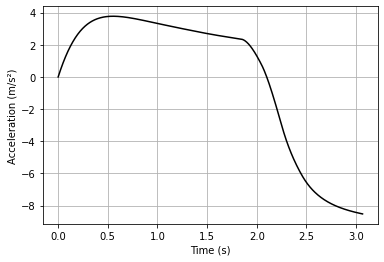

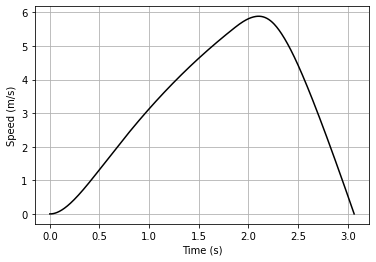

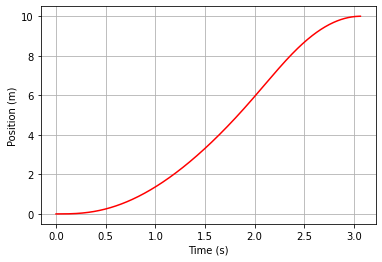

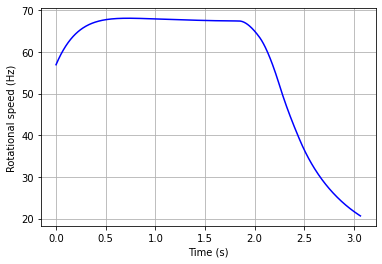

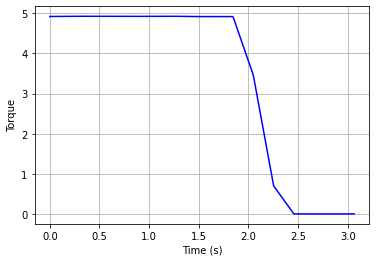

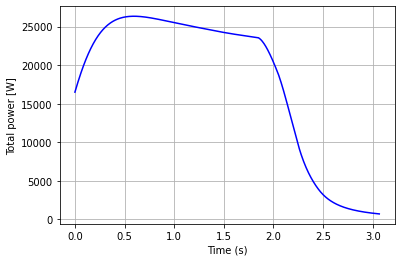

In [10]:
plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [11]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [12]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [7]:
api.variable_viewer(OUTPUT_FILE)

In [22]:
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].